## Project Overview

**Project Title**

**Predicting Empathy Scores**: Leveraging Eye-Tracking Data for Recruitment Insights

**Project Overview**

The objective of this project is to develop a predictive model for assessing individuals' empathy scores using eye-tracking data collected during specific tasks. The primary goal is to leverage advanced data analysis techniques to understand the relationship between participants' eye movement patterns and their levels of empathy. By achieving this, we aim to provide a tool that can be used by Human Resources (HR) departments during recruitment processes to better understand the empathy traits of potential candidates.

**Background and Context**

In collaboration with a university, we collected eye-tracking data from a diverse group of 60 participants during controlled tasks. These tasks were designed to elicit natural eye movement behaviors while participants interacted with various stimuli. Alongside the eye-tracking data, we gathered self-reported empathy scores from a questionnaire provided to each participant.

**Project Significance**

The project's significance lies in the potential application of cutting-edge data science techniques to enhance the recruitment process by quantitatively assessing empathy traits, a crucial soft skill that can impact team dynamics, communication, and overall workplace effectiveness. If successful, this tool has the potential to revolutionize how companies evaluate and select candidates, ensuring a more empathetic workforce and fostering a positive work environment.

**Key Steps and Goals**

1. **Data Exploration and Preprocessing:** Our initial steps involve understanding the eye-tracking data, identifying relevant features, and preprocessing the data to handle missing values and ensure its quality.

2. **Feature Selection:** We will carefully select the most informative features that contribute to predicting empathy scores, considering both the eye-tracking data and the questionnaire responses.

3. **Model Development:** Employing state-of-the-art machine learning techniques, we will develop a predictive model that can accurately estimate empathy scores based on the selected features.

4. **Model Interpretability:** Given the importance of GDPR regulations and the need for transparency in decision-making, we will ensure that our model is interpretable, enabling us to explain to individuals the basis for their predicted empathy scores.

5. **Evaluation and Reporting:** We will thoroughly evaluate the performance of our predictive model, considering metrics such as accuracy, precision, recall, and F1-score. Additionally, we will analyze the model's strengths and limitations in the context of empathy assessment.

**Expected Outcomes**

We anticipate providing HR departments with an effective and explainable tool for assessing candidates' empathy levels using eye-tracking data. Our model will offer insights into the factors driving empathy scores, thus enabling companies to make more informed and empathetic hiring decisions. Additionally, our analysis may uncover valuable patterns within the data that could have broader implications for future feature development and commercialization.

Through this project, we aim to bridge the gap between cutting-edge data science and practical HR needs, contributing to a more empathetic and harmonious work environment.



In [ ]:
# importing basic
from google.colab import drive
import os
import pandas as pd
import numpy as np
import warnings

# for visualization
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# for model training and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# mounting the drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Data Preprocessing and Dimension Reduction
In the course of the experiment, a multitude of features were extracted. Each participant's observations were meticulously collected and stored in separate files, yielding 60 distinct files for each individual. Remarkably, every participant's dataset boasts over 82,000 observations, each encompassing a collection of 96 distinct features. However, certain features within each observation exhibited redundancy, while others suffered from frequent missing data points. In order to streamline the data and enhance its practicality for analysis, a dimensionality reduction strategy is being employed. This process involves filtering out specific features (columns) based on three distinct criteria, thereby refining the dataset to a more manageable form.

**Criteria for Column Filtering**

1. Features with over 40% of missing data will be excluded from the dataset, as they are unlikely to contribute meaningfully to our predictive model.

2. Additionally, columns containing only a single unique value throughout the dataset will be removed. These columns lack variability, making them less informative for our analysis.

3. Removing miscellenous columns like "Project Name" etc that would not play any part in the traning or prediction phase

To facilitate this preprocessing, three separate datasets will be utilized, each featuring the same set of features. This approach enables a more focused and streamlined exploration of the data, while still capturing the essence of the original 60 datasets.





In [ ]:
# declaring the data path
folder_path = "drive/MyDrive/extracted_data/"
chunk_size = 100000  # Specify the desired chunk size


def read_data(folder_path, columns=None, chunk_size=100000, dataset_count=None):
    count = 0
    data = pd.DataFrame()

    # Loop through the files in the folder and read data in chunks
    for filename in os.listdir(folder_path):
        count += 1
        file_path = os.path.join(folder_path, filename)
        try:
            for chunk in pd.read_csv(file_path, chunksize=chunk_size, sep='\t', usecols=columns):
                temp_df = chunk
                data = data.append(temp_df, ignore_index=True)
                if dataset_count is not None and count >= dataset_count:
                    return data
        except:
            pass
        if dataset_count is not None and count >= dataset_count:
            return data
    return data


In [ ]:
# reading in the sample data
data = read_data(folder_path, dataset_count = 2)

In [ ]:
# checking the shape of the sample data
data.shape

(129056, 96)

In [ ]:
# checking the participants name present in the sample data
data['Participant name'].unique()

array(['Participant0001', 'Participant0002'], dtype=object)

In [ ]:
# filtering out the columns with 40% null values
threshold = .40
cols = [f for f in data.columns if (data[f].isnull().sum() / data.shape[0]) < threshold]

# filtering out columns that have only one unique value
cols = [f for f in cols if data[f].nunique() > 1]

# removing all timestamps columns
timestamps = ['Recording timestamp', 'Computer timestamp', 'Recording date', 'Recording date UTC',
               'Recording start time', 'Recording start time UTC', 'Eyetracker timestamp', "Export date"]
cols = [f for f in cols if f not in timestamps]

# removing other misc columns that won't needed in this project
misc_cols = ["Sensor", "Project name",  "Recording name", "Presented Stimulus name", "Presented Stimulus name"
              ,"Presented Media name"]
cols = [f for f in cols if f not in misc_cols]

# removing all timestamps columns
timestamps = ['Recording timestamp', 'Computer timestamp', 'Recording date', 'Recording date UTC',
               'Recording start time', 'Recording start time UTC', 'Eyetracker timestamp']
cols = [f for f in cols if f not in timestamps]

len(cols)

39

## Filtered columns
Below are the filtered columns and a brief description of what each column/feature is.



1. **Sensor:** This column likely indicates the specific sensor or device used for eye-tracking measurements.

2. **Project name:** The name of the project or study where the data was collected.

3. **Export date:** The date when the data was exported or saved.

4. **Participant name:** The name or identifier of the participant involved in the study.

5. **Recording name:** The name or identifier of the recording session or data file.

6. **Recording duration:** The duration of the recording in some time unit (e.g., milliseconds, seconds).

7. **Gaze point X, Gaze point Y:** The X and Y coordinates of the gaze point, typically indicating where the participant is looking on a screen or stimulus.

8. **Gaze point left X, Gaze point left Y:** Similar to the above, but specifically for the left eye.

9. **Gaze point right X, Gaze point right Y:** Similar to the above, but specifically for the right eye.

10. **Gaze direction left X, Gaze direction left Y, Gaze direction left Z:** Components of the gaze direction vector for the left eye.

11. **Gaze direction right X, Gaze direction right Y, Gaze direction right Z:** Components of the gaze direction vector for the right eye.

12. **Validity left, Validity right:** Indicators of the validity or quality of gaze data for the left and right eyes (e.g., valid, invalid).

13. **Eye position left X, Eye position left Y, Eye position left Z:** Eye position coordinates for the left eye.

14. **Eye position right X, Eye position right Y, Eye position right Z:** Eye position coordinates for the right eye.

15. **Gaze point left X (DACSmm), Gaze point left Y (DACSmm), Gaze point right X (DACSmm), Gaze point right Y (DACSmm):** Gaze point coordinates in DACS (Data Acquisition and Control System) units for left and right eyes.

16. **Gaze point X (MCSnorm), Gaze point Y (MCSnorm), Gaze point left X (MCSnorm), Gaze point left Y (MCSnorm):** Gaze point coordinates normalized to MCS (Monitor Coordinate System) for left and right eyes.

17. **Presented Stimulus name:** The name or identifier of the stimulus presented during the recording.

18. **Presented Media name:** The name or identifier of the media presented.

19. **Presented Media width, Presented Media height:** Dimensions of the presented media.

20. **Presented Media position X (DACSpx), Presented Media position Y (DACSpx):** Media position in DACS units.

21. **Original Media width, Original Media height:** Dimensions of the original media (before presentation).

22. **Eye movement type:** Classification of the type of eye movement observed.

23. **Gaze event duration:** Duration of the gaze event (e.g., fixations, saccades).

24. **Eye movement type index:** Index associated with the eye movement type.



In [ ]:
# loading the full data using the filtered columns
data = read_data(folder_path, columns = cols, dataset_count = 60)

## Data Exploration
In this section, we would get to know more about the filetered data. More cleaning would be carried out as each column is studied before training the model.

In [ ]:
# checking for null values
data.isnull().sum()


Participant name                             0
Recording duration                           0
Gaze point X                            757426
Gaze point Y                            757426
Gaze point left X                      1147608
Gaze point left Y                      1147608
Gaze point right X                     1161103
Gaze point right Y                     1161103
Gaze direction left X                  1147608
Gaze direction left Y                  1147608
Gaze direction left Z                  1147608
Gaze direction right X                 1161103
Gaze direction right Y                 1161103
Gaze direction right Z                 1161103
Validity left                           133060
Validity right                          133060
Eye position left X (DACSmm)           1147608
Eye position left Y (DACSmm)           1147608
Eye position left Z (DACSmm)           1147608
Eye position right X (DACSmm)          1161103
Eye position right Y (DACSmm)          1161103
Eye position 

In [ ]:
# checking the datatypes of each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5349398 entries, 0 to 5349397
Data columns (total 40 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   Participant name                     object 
 1   Recording duration                   int64  
 2   Gaze point X                         float64
 3   Gaze point Y                         float64
 4   Gaze point left X                    float64
 5   Gaze point left Y                    float64
 6   Gaze point right X                   float64
 7   Gaze point right Y                   float64
 8   Gaze direction left X                object 
 9   Gaze direction left Y                object 
 10  Gaze direction left Z                object 
 11  Gaze direction right X               object 
 12  Gaze direction right Y               object 
 13  Gaze direction right Z               object 
 14  Validity left                        object 
 15  Validity right                  

In [ ]:
# checking the summary stats of each column in the data
data.describe()

,Recording duration,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Presented Media width,Presented Media height,Presented Media position X (DACSpx),Presented Media position Y (DACSpx),Original Media width,Original Media height,Gaze event duration,Eye movement type index
count,5.349398e+06,4.591972e+06,4.591972e+06,4.201790e+06,4.201790e+06,4.188295e+06,4.188295e+06,4.850257e+06,4.850257e+06,4.850257e+06,4.850257e+06,4.850257e+06,4.850257e+06,5.346301e+06,5.346301e+06
mean,1.080419e+05,9.188933e+02,4.588993e+02,8.521668e+02,4.658951e+02,9.833664e+02,4.527201e+02,1.516510e+03,1.101865e+03,2.020957e+02,-1.093696e+01,1.516839e+03,1.105890e+03,3.003500e+02,3.531867e+02
std,4.987309e+04,3.003378e+02,2.943322e+02,3.049049e+02,2.950659e+02,2.960014e+02,2.908094e+02,2.184688e+02,2.248904e+02,1.091826e+02,1.124933e+02,6.206035e+02,4.893543e+02,9.795218e+02,5.336442e+02
min,5.359000e+03,-1.407000e+03,-1.235000e+03,-6.420000e+02,-1.401000e+03,-1.407000e+03,-1.235000e+03,1.080000e+03,1.080000e+03,-7.470000e+02,-1.168000e+03,6.400000e+02,4.160000e+02,8.000000e+00,1.000000e+00
25%,6.593900e+04,7.620000e+02,2.510000e+02,6.880000e+02,2.560000e+02,8.260000e+02,2.510000e+02,1.493000e+03,1.080000e+03,2.140000e+02,0.000000e+00,8.970000e+02,6.490000e+02,3.300000e+01,7.300000e+01
50%,1.005030e+05,9.170000e+02,4.610000e+02,8.500000e+02,4.660000e+02,9.840000e+02,4.560000e+02,1.493000e+03,1.080000e+03,2.140000e+02,0.000000e+00,2.000000e+03,1.447000e+03,1.170000e+02,1.730000e+02
75%,1.447370e+05,1.062000e+03,6.790000e+02,1.002000e+03,6.850000e+02,1.143000e+03,6.680000e+02,1.493000e+03,1.080000e+03,2.140000e+02,0.000000e+00,2.000000e+03,1.447000e+03,2.830000e+02,3.850000e+02
max,2.333600e+05,3.585000e+03,2.593000e+03,3.585000e+03,2.593000e+03,2.521000e+03,2.374000e+03,3.415000e+03,3.415000e+03,4.200000e+02,0.000000e+00,3.415000e+03,3.415000e+03,2.162300e+04,5.126000e+03


In [ ]:
# # displaying the full width of the data
# pd.set_option("display.max_columns", None)

# # displaying the first 5 rows
# data.head()

**Validity Right** and **Valididty Left**

I'm beginning the visualization process by focusing on the columns "Validity Right" and "Validity Left." These columns indicate the validity of each observation during the experiment, providing essential information on the reliability of the data. By visualizing these columns, I can gain insights into the distribution of valid and invalid observations, helping me identify patterns that might require further filtering or preprocessing. This initial step allows me to ensure that the data I work with is of high quality and aligns with the research goals.

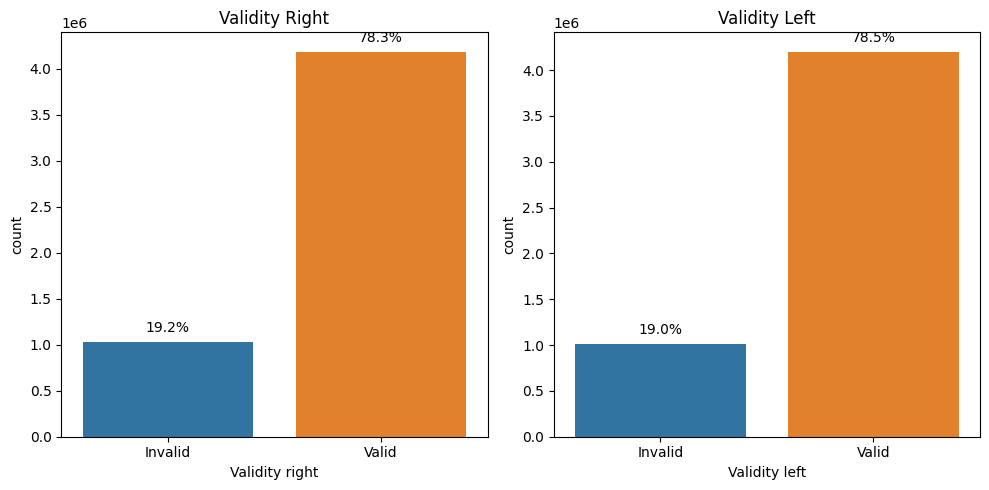

In [ ]:
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot "Validity right" on the first axis
ax1 = sns.countplot(data=data, x='Validity right', ax=axes[0])
axes[0].set_title('Validity Right')

# Calculate the total count for "Validity right"
total_count_right = len(data['Validity right'])

# Annotate the bars in the first plot with percentage values
for p in ax1.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_count_right)
    ax1.annotate(percentage,
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 10),
                 textcoords='offset points')

# Plot "Validity left" on the second axis
ax2 = sns.countplot(data=data, x='Validity left', ax=axes[1])
axes[1].set_title('Validity Left')

# Calculate the total count for "Validity left"
total_count_left = len(data['Validity left'])

# Annotate the bars in the second plot with percentage values
for p in ax2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_count_left)
    ax2.annotate(percentage,
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 10),
                 textcoords='offset points')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# dropping the rows/observations where there is an invalid or missing observation for both validity Right and Left

data = data.loc[(data['Validity left'] == 'Valid') & (data['Validity right'] == 'Valid')]

data.head()

,Participant name,Recording duration,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,...,Gaze point left Y (MCSnorm),Presented Media width,Presented Media height,Presented Media position X (DACSpx),Presented Media position Y (DACSpx),Original Media width,Original Media height,Eye movement type,Gaze event duration,Eye movement type index
3,Participant0001,83579,796.0,677.0,782.0,688.0,811.0,666.0,"0,03092","0,16640",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saccade,42.0,1.0
4,Participant0001,83579,805.0,717.0,782.0,718.0,828.0,716.0,"0,03093","0,17749",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saccade,42.0,1.0
5,Participant0001,83579,831.0,706.0,790.0,668.0,871.0,743.0,"0,03421","0,15923",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saccade,42.0,1.0
26,Participant0001,83579,584.0,889.0,485.0,940.0,683.0,838.0,"-0,07869","0,25545",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saccade,17.0,2.0
27,Participant0001,83579,696.0,808.0,684.0,744.0,709.0,873.0,"-0,00534","0,18684",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saccade,17.0,2.0


### Data Cleaning

**Dealing with Null Values and Wrong Data types**

**MCSnorm Related Columns**

"(MCSnorm)" in the context of eye-tracking data likely refers to the normalization of gaze point coordinates to the Monitor Coordinate System (MCS). The Monitor Coordinate System is a common reference frame used in eye-tracking experiments, especially when dealing with gaze points on a computer screen or monitor. Normalizing the coordinates means transforming them into a standardized scale that is independent of the specific monitor or screen size.

Missing date in these columns could be as a results of glitch or technincal issues from the machine. So I would be replacing the missing values with "0" which would signify missing data.

In [ ]:
# replacing null values with 0
data[['Gaze point X (MCSnorm)', 'Gaze point Y (MCSnorm)',
      'Gaze point left X (MCSnorm)',
      'Gaze point left Y (MCSnorm)']] = data[['Gaze point X (MCSnorm)', 'Gaze point Y (MCSnorm)',
                                              'Gaze point left X (MCSnorm)', 'Gaze point left Y (MCSnorm)']].fillna('0')


**Gaze Related Columns**

The **Gaze Direction**, **Gaze Point**, and **Eye Position** columns contain incorrect data types because they contain commas (',') instead of ('.') which serves as decimal points. I'll address this issue by removing the commas and converting these columns back to their appropriate numeric data types to ensure data accuracy and consistency.

These group of columns also have same number of missing values in the data, so after fixing the datatypes, I would be replacing the null values with 0 to indicate the absence of the data for that particular observation


In [ ]:
# Columns and characters to replace
columns_to_replace = {
    "Gaze direction left X": ",",
    "Gaze direction left Y": ",",
    "Gaze direction left Z": ",",
    "Gaze direction right X": ",",
    "Gaze direction right Y": ",",
    "Gaze direction right Z": ",",
    "Eye position left X (DACSmm)": ",",
    "Eye position left Y (DACSmm)": ",",
    "Eye position left Z (DACSmm)": ",",
    "Eye position right X (DACSmm)": ",",
    "Eye position right Y (DACSmm)": ",",
    "Eye position right Z (DACSmm)": ",",
    "Gaze point left X (DACSmm)": ",",
    "Gaze point left Y (DACSmm)": ",",
    "Gaze point right X (DACSmm)": ",",
    "Gaze point right Y (DACSmm)": ",",
    "Gaze point X (MCSnorm)": ",",
    "Gaze point Y (MCSnorm)": ",",
    "Gaze point left X (MCSnorm)": ",",
    "Gaze point left Y (MCSnorm)": ","
}

# Apply the replacements and convert columns to float
data = data.replace(columns_to_replace, "", regex=True)
data = data.astype({
    "Gaze direction left X": float,
    "Gaze direction left Y": float,
    "Gaze direction left Z": float,
    "Gaze direction right X": float,
    "Gaze direction right Y": float,
    "Gaze direction right Z": float,
    "Eye position left X (DACSmm)": float,
    "Eye position left Y (DACSmm)": float,
    "Eye position left Z (DACSmm)": float,
    "Eye position right X (DACSmm)": float,
    "Eye position right Y (DACSmm)": float,
    "Eye position right Z (DACSmm)": float,
    "Gaze point left X (DACSmm)": float,
    "Gaze point left Y (DACSmm)": float,
    "Gaze point right X (DACSmm)": float,
    "Gaze point right Y (DACSmm)": float,
    "Gaze point X (MCSnorm)": float,
    "Gaze point Y (MCSnorm)": float,
    "Gaze point left X (MCSnorm)": float,
    "Gaze point left Y (MCSnorm)": float
})

**Media Related Columns**

The null values in these columns is likely due to the absence of the media or malfunction of some sort. I would be replacing the null values with the most common value in each column.

In [ ]:
media_cols = ["Presented Media width", "Presented Media height", "Presented Media position X (DACSpx)",
 "Presented Media position Y (DACSpx)", "Original Media width", "Original Media height"]

# replacing the null values for each column
for col in media_cols:
    most_common_value = data[col].value_counts().idxmax()
    data[col].fillna(most_common_value, inplace=True)


In [ ]:
# checking to confirm we have no null values present in the data
data.isnull().sum()

Participant name                       0
Recording duration                     0
Gaze point X                           0
Gaze point Y                           0
Gaze point left X                      0
Gaze point left Y                      0
Gaze point right X                     0
Gaze point right Y                     0
Gaze direction left X                  0
Gaze direction left Y                  0
Gaze direction left Z                  0
Gaze direction right X                 0
Gaze direction right Y                 0
Gaze direction right Z                 0
Validity left                          0
Validity right                         0
Eye position left X (DACSmm)           0
Eye position left Y (DACSmm)           0
Eye position left Z (DACSmm)           0
Eye position right X (DACSmm)          0
Eye position right Y (DACSmm)          0
Eye position right Z (DACSmm)          0
Gaze point left X (DACSmm)             0
Gaze point left Y (DACSmm)             0
Gaze point right

In [ ]:
# collecting the participant unique number
data['Participant nr'] = data['Participant name'].apply(lambda x: x[-2:]).astype('int32')

# merging the empathy score from the questionaiire dataset
emp = pd.read_csv('/content/drive/MyDrive/Questionnaire_datasetIA.csv', encoding='latin-1')
data = pd.merge(data, emp[['Participant nr', 'Total Score original']], on='Participant nr')

## Data Visualization

For this section, I would be spliting the columns into categorical and numerical data types. This would enable me run through visualization easily

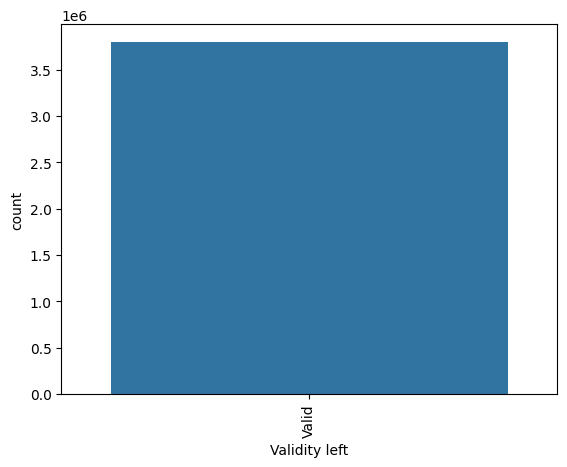

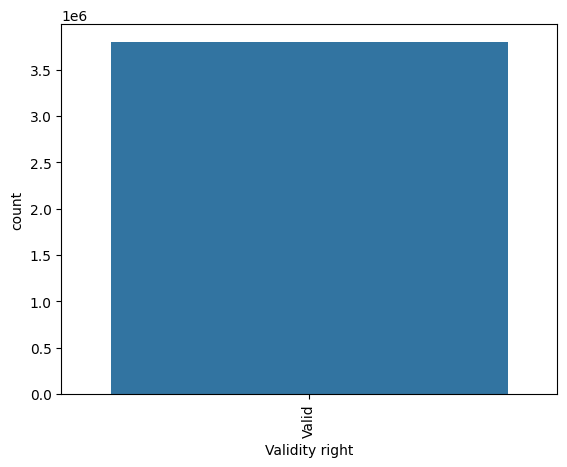

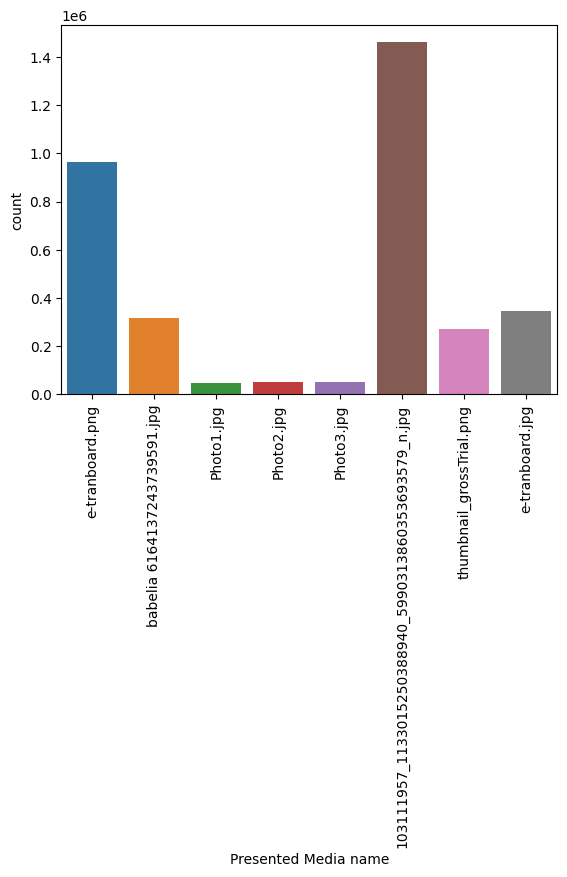

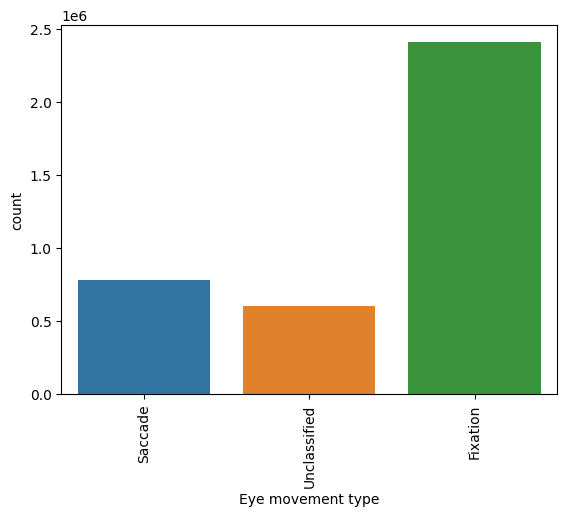

In [ ]:
# splitting the columns into categorical and numerical columns
cat = [f for f in data.columns if data[f].dtype == "O" and data[f].nunique() < 15]
for col in cat:
  sns.countplot(data = data, x = col)
  plt.xticks(rotation = 90)
  plt.show()

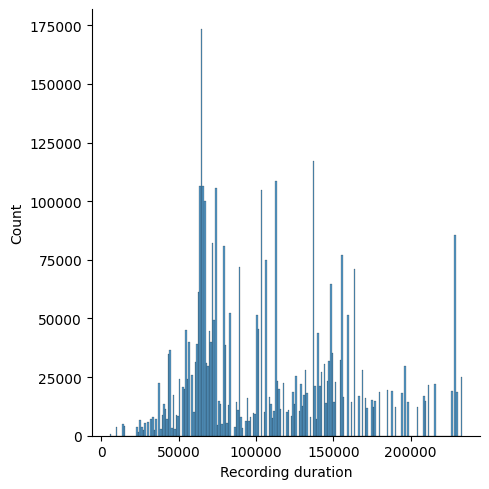

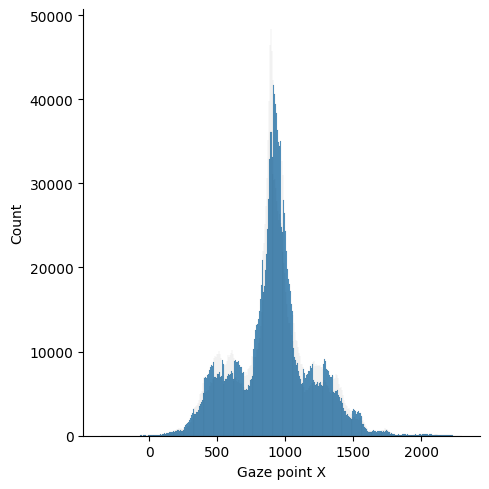

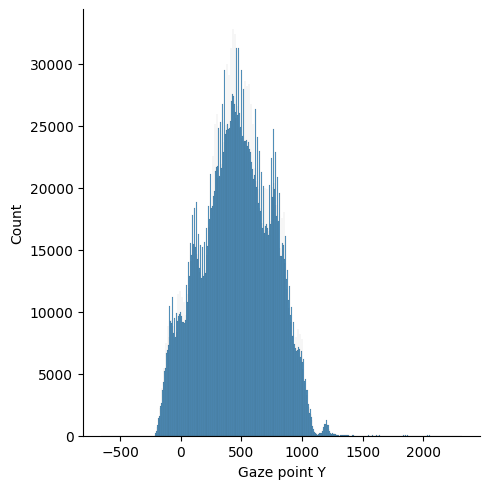

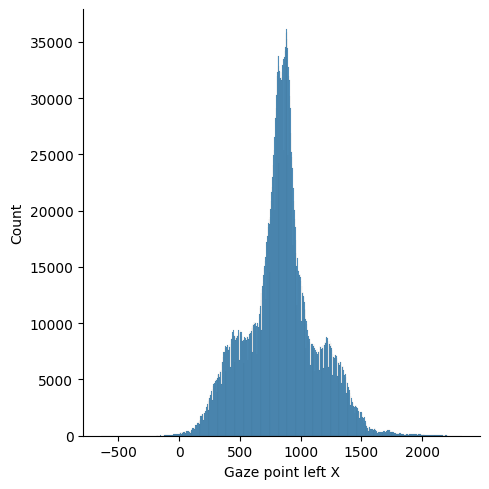

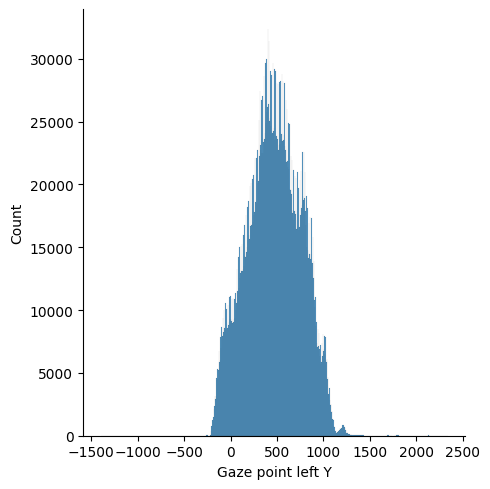

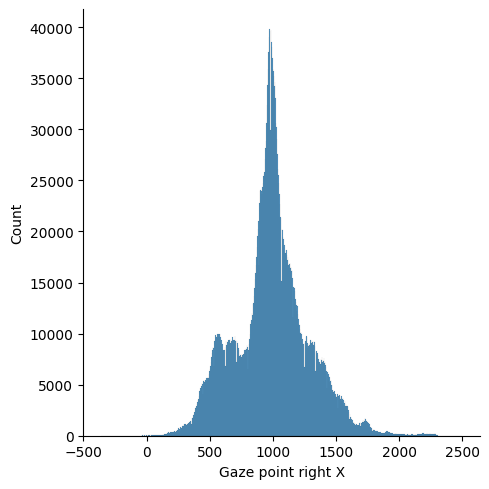

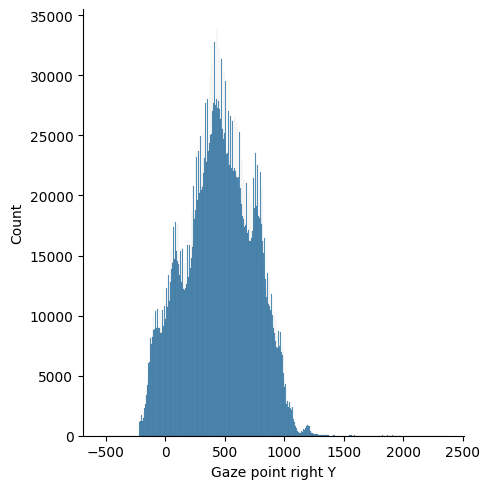

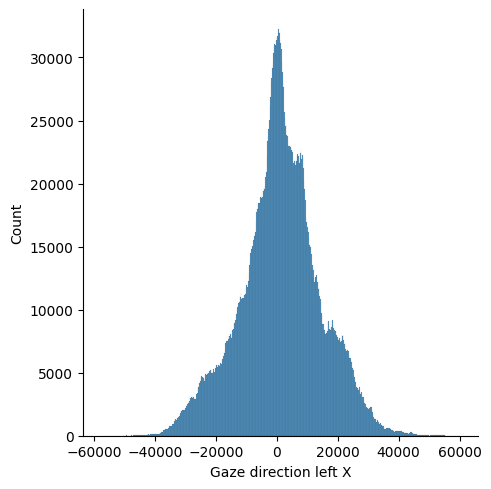

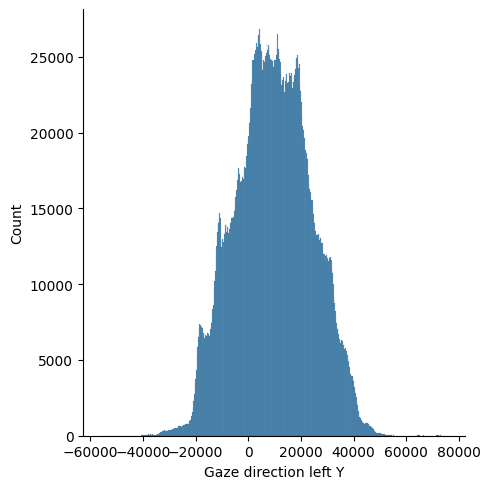

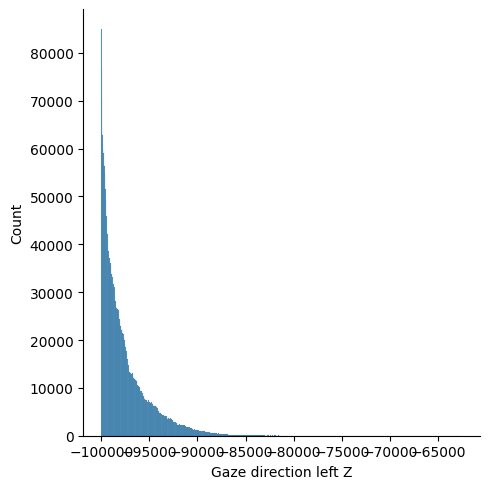

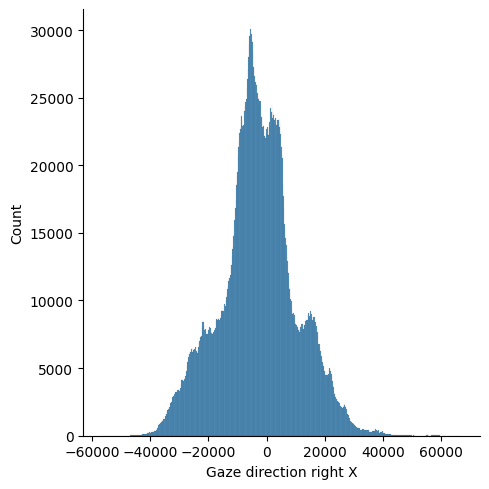

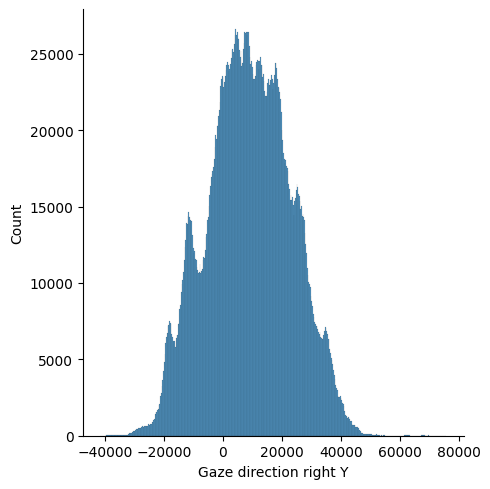

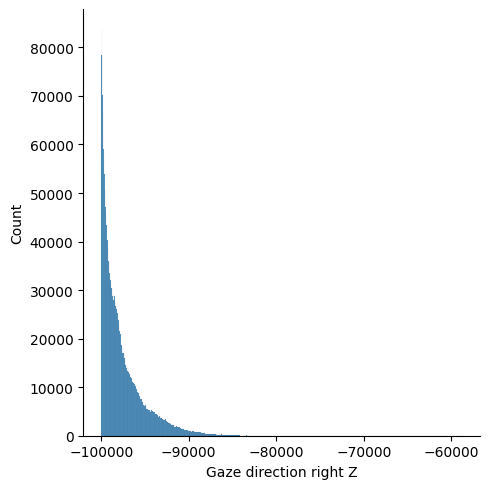

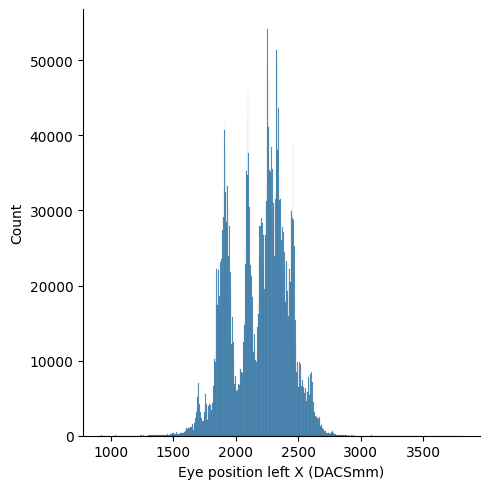

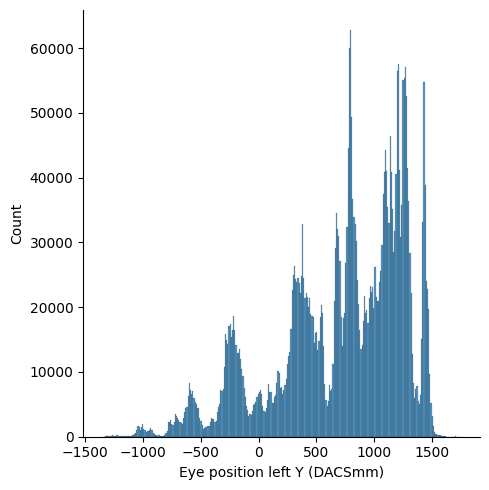

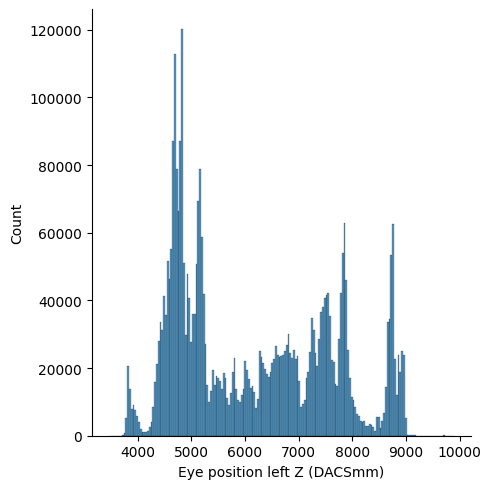

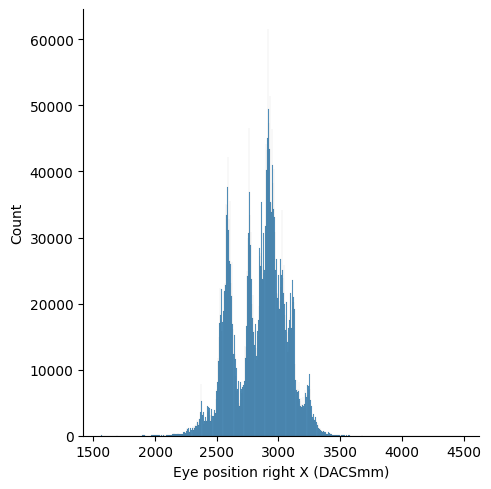

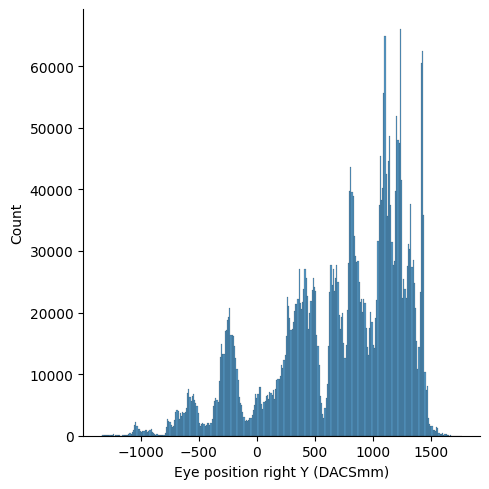

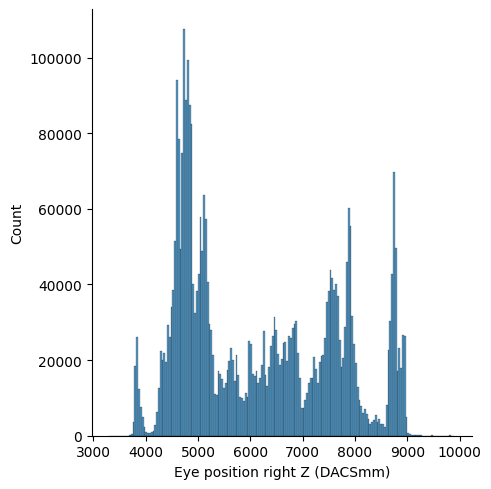

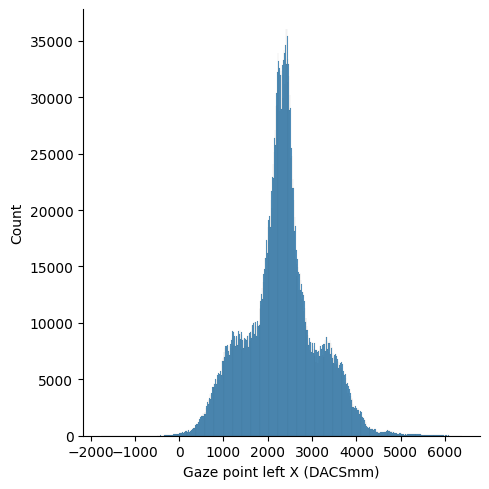

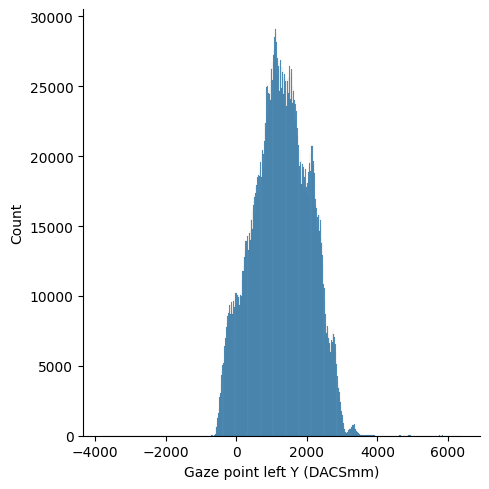

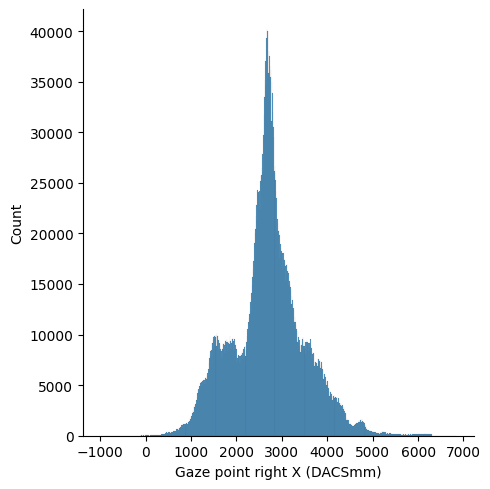

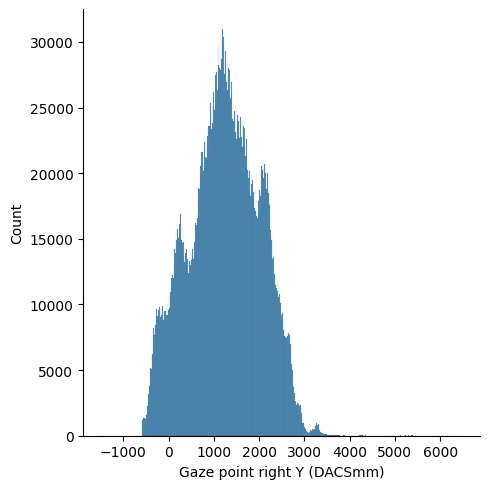

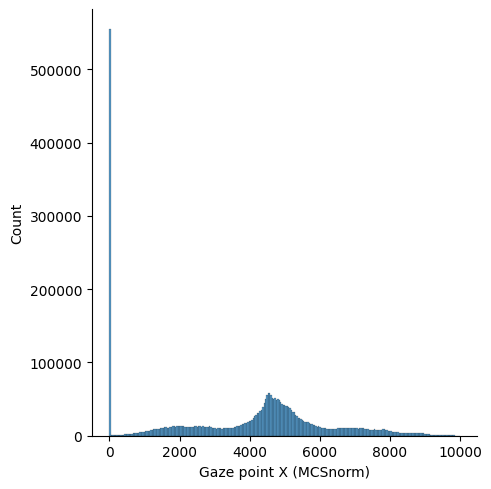

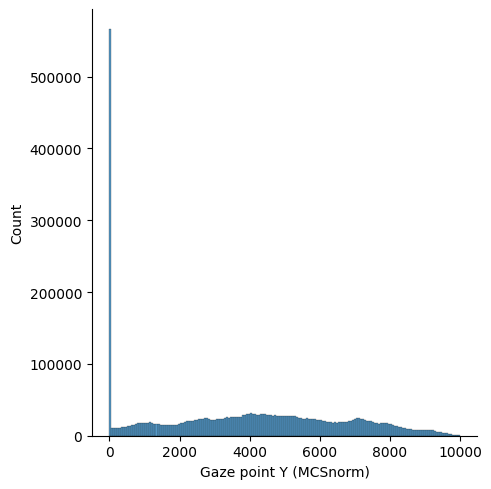

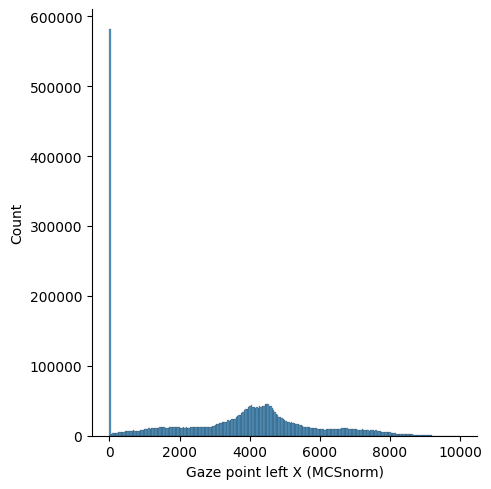

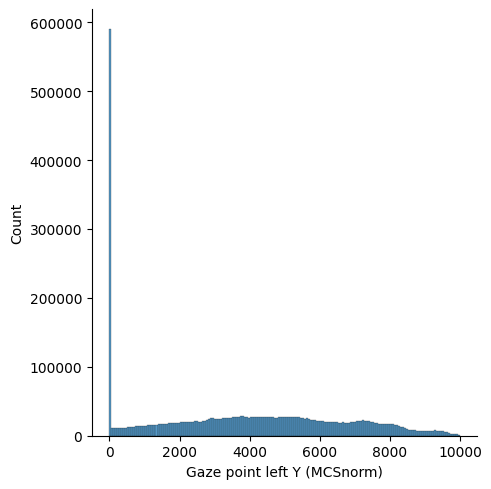

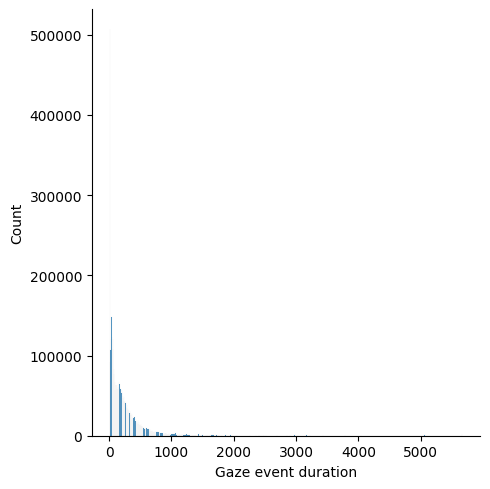

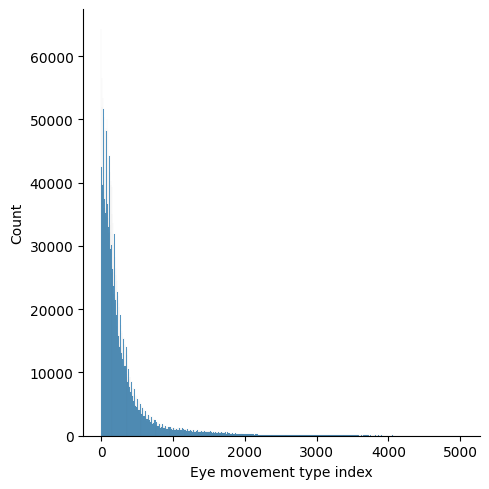

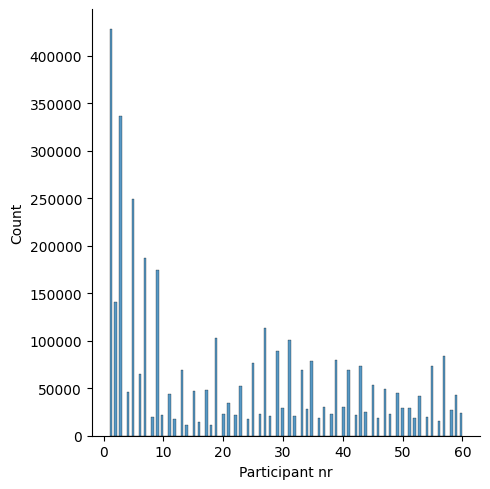

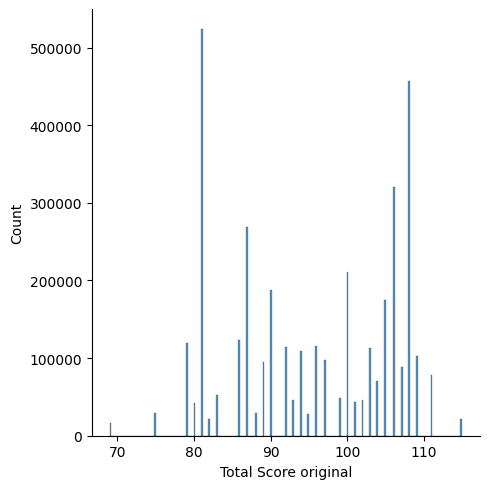

In [ ]:
for col in [f for f in data.columns if data[f].dtype != "O" and data[f].nunique() >= 10]:
  sns.displot(data = data, x = col)
  plt.show()

In [ ]:
# columns to drop from data
data = data.drop(['Presented Stimulus name', 'Presented Media name', 'Presented Media width',
                  'Presented Media height', 'Presented Media position X (DACSpx)', 'Presented Media position Y (DACSpx)', 'Original Media width',
                  'Original Media height', 'Sensor', 'Project name', 'Export date', 'Participant name',
                  'Recording name', 'Validity left', 'Validity right'], axis = 1)

## Data Preprocessing
Normalization is a common preprocessing step before training machine learning models, as it can help improve the convergence and performance of many algorithms. It ensures that all features have similar scales, preventing one feature from dominating the learning process simply because of its larger magnitude.

In [ ]:
data.columns

Index(['Participant name', 'Recording duration', 'Gaze point X',
       'Gaze point Y', 'Gaze point left X', 'Gaze point left Y',
       'Gaze point right X', 'Gaze point right Y', 'Gaze direction left X',
       'Gaze direction left Y', 'Gaze direction left Z',
       'Gaze direction right X', 'Gaze direction right Y',
       'Gaze direction right Z', 'Validity left', 'Validity right',
       'Eye position left X (DACSmm)', 'Eye position left Y (DACSmm)',
       'Eye position left Z (DACSmm)', 'Eye position right X (DACSmm)',
       'Eye position right Y (DACSmm)', 'Eye position right Z (DACSmm)',
       'Gaze point left X (DACSmm)', 'Gaze point left Y (DACSmm)',
       'Gaze point right X (DACSmm)', 'Gaze point right Y (DACSmm)',
       'Gaze point X (MCSnorm)', 'Gaze point Y (MCSnorm)',
       'Gaze point left X (MCSnorm)', 'Gaze point left Y (MCSnorm)',
       'Presented Media name', 'Presented Media width',
       'Presented Media height', 'Presented Media position X (DACSpx)',
  

In [ ]:
# encoding the eye movement type column to numerical values
data['Eye movement type'] = data['Eye movement type'].map({'Unclassified':0, 'Saccade': 1, 'Fixation':2}).astype('int32')

In [ ]:
# columns to normalize
columns_to_normalize = data.drop(['Participant nr', 'Total Score original'], axis = 1).columns

In [ ]:
# MinMaxScaler object
scaler = StandardScaler()

# Fit the scaler to the data and transform the selected columns
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

In [ ]:
# saving the data to file to use later
data.to_csv('drive/MyDrive/Processed data', index = False)

Due to the limited available RAM, I'll be training the model in a separate notebook. The training process requires a significant amount of memory, which could cause the Runtime session to restart. To avoid this issue, I've divided the notebook into two separate files.